In [82]:
import os
import numpy as np
from scipy.fftpack import dct
from pywt import dwt2
from skimage.io import imread, imshow
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt
from IPython import display

from utils import (
    SoftThresh,
    ShrinkageOperator,
    Proj
)

%matplotlib inline

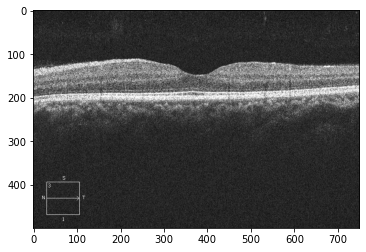

In [83]:
image_path = "OCTID_NORMAL"
image_name = "NORMAL1.jpeg"
image = os.path.join(image_path, image_name)

oct_image = imread(image)
plt.imshow(oct_image, cmap='gray')

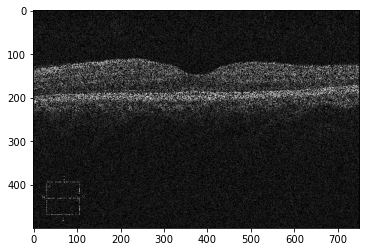

In [84]:
# Taking the first of the 3 channels, as they are all the same.
X = oct_image[:,:,0]
h, w = X.shape

compression_factor = 2
mask = np.random.randint(2, size=(h,w))
D = X*mask

plt.imshow(X*mask, cmap="gray")

In [85]:
def AUpdate(W, Y1, mu):
    Z = W - (1/mu)*Y1
    return ShrinkageOperator(Z, 1/mu)

def WUpdate(mask, A, W, E, D, B1, B2t, Y1, Y2, mu, nu1, lmda):
    Z = B1 @ W @ B2t + E - D + (1/mu)*Y2
    Z = Proj(Z, mask)
    Z = B1.T @ Z @ B2t.T + W - A - (1/mu)*Y1
    Z = W - (1/nu1)*Z
    return SoftThresh(Z, lmda/(nu1*mu))

def EUpdate(mask, W, E, D, B1, B2t, Y2, mu, nu2, a):
    Z = (E + B1 @ W @ B2t) - D
    Z = Proj(Z, mask) + (1/mu)*Y2
    Z =  E - (1/nu2)*Z
    return SoftThresh(Z, a/(mu*nu2))

def Y1Update(mask, W, E, D, B1, B2t, Y1, mu):
    Z = B1 @ W @ B2t + E - D
    return Y1 + mu*Proj(Z, mask)

def Y2Update(A, W, Y2, mu):
    return Y2 + mu*(A - W)

def muUpdate(mu, ro):
    return mu*ro

In [87]:
(cA, (cH, cV, cD)) = dwt2(np.eye(h), 'db1')
upper = np.concatenate([cA, cH])
lower = np.concatenate([cV, cD])
B1 = np.concatenate([upper, lower], axis=1)

In [73]:
basis_ = "dwt"

if basis_ == "dct":
    B1 = dct(np.eye(h), norm='ortho', axis=0).T
    B2t = dct(np.eye(w), norm='ortho', axis=0)
else: 
    # pywt.dwt2 is the discrete wavelet transform in 2D. It returns the transformed array
    # in 4 equaly sized block matrices which are simplpy regions of the entire 2D transform
    
    (cA, (cH, cV, cD)) = dwt2(np.eye(h), 'db1')
    upper = np.concatenate([cA, cH])
    lower = np.concatenate([cV, cD])
    B1 = np.concatenate([upper, lower], axis=1)
    
    (cA, (cH, cV, cD)) = dwt2(np.eye(w), 'db1')
    upper = np.concatenate([cA, cH])
    lower = np.concatenate([cV, cD])
    B2t = np.concatenate([upper, lower], axis=1)

W = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)

# Initialize the variable for the ptimization algorithm
A = np.copy(W)
E = np.zeros_like(D)
Y1 = np.zeros_like(D)
Y2 = np.zeros_like(D)
nu1 = 3
nu2 = 3
mu = 0.5
lmda = 0.001
a = 0.85
ro = 1.01

# ro = 1.01

Iteration 1:	Reconstruction Error: 33413.99	Spectral Norm W: 443427.14
Resulting Reconstruction after 0 interations:


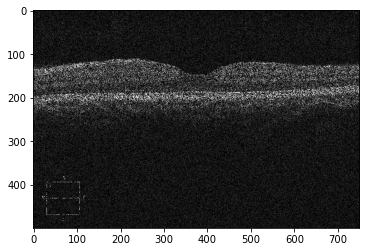

Iteration 51:	Reconstruction Error: 242365437596093.66	Spectral Norm W: 4536439519929224.00


KeyboardInterrupt: 

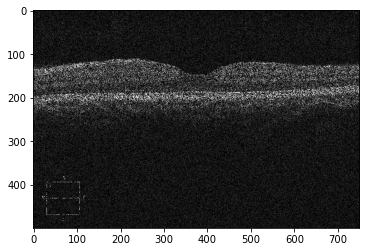

In [74]:
reconstruction_error = []
spectral_norm = []

iters = 2000
for i in range(iters):
    A = AUpdate(W, Y1, mu)
    W = WUpdate(mask, A, W, E, D, B1, B2t, Y1, Y2, mu, nu1, lmda)
    E = EUpdate(mask, W, E, D, B1, B2t, Y2, mu, nu2, a)
    Y1 = Y1Update(mask, W, E, D, B1, B2t, Y1, mu)
    Y2 = Y2Update(A, W, Y2, mu)
    
    spectral_norm.append(np.linalg.norm(W, ord="nuc"))
    reconstruction_error.append(np.linalg.norm(X - B1 @ W @ B2t))
    if i % 50 == 0:
        print(
            f"Iteration {i+1}:\t"\
            f"Reconstruction Error: {reconstruction_error[-1]:.2f}\t"\
            f"Spectral Norm W: {spectral_norm[-1]:.2f}"
        )
    if i % 250 == 0:
        print(f"Resulting Reconstruction after {i} interations:")
        plt.imshow(B1 @ W @ B2t, cmap="gray")
        display.display(plt.gcf())
        
print("\n\n Final Reconstruction")
plt.imshow(B1 @ W @ B2t, cmap="gray");

In [ ]:
plt.imshow(X, cmap="gray")

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 7))

axes[0].plot(reconstruction_error, c='b', label=r"Reconstruction Error: $||B_{1} W B_{2}^{\mathbf{T}} - X ||_{2}$")
axes[1].plot(spectral_norm, c='r', label=r"Spectral Norm W: $|| W ||_{\ast}$")

axes[0].legend()
axes[1].legend()

plt.show()

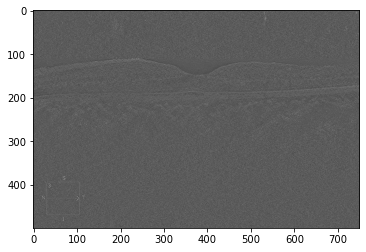

In [ ]:
plt.imshow(X - B1 @ W @ B2t, cmap="gray")